# Find DE genes


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import confusion_matrix
from IPython.display import display
import matplotlib.pyplot as plt
import os
from adjustText import adjust_text
import seaborn as sns

In [3]:
from matplotlib.cm import get_cmap
cmap_tab10 = get_cmap('tab10')

import matplotlib as mpl

In [4]:
sc.set_figure_params(dpi_save=300)
cmap = mpl.colors.ListedColormap([cmap_tab10.colors[0],cmap_tab10.colors[3],cmap_tab10.colors[2],cmap_tab10.colors[4],cmap_tab10.colors[1],cmap_tab10.colors[8],cmap_tab10.colors[9]])

In [34]:
microglia=sc.read("microglia.h5ad")

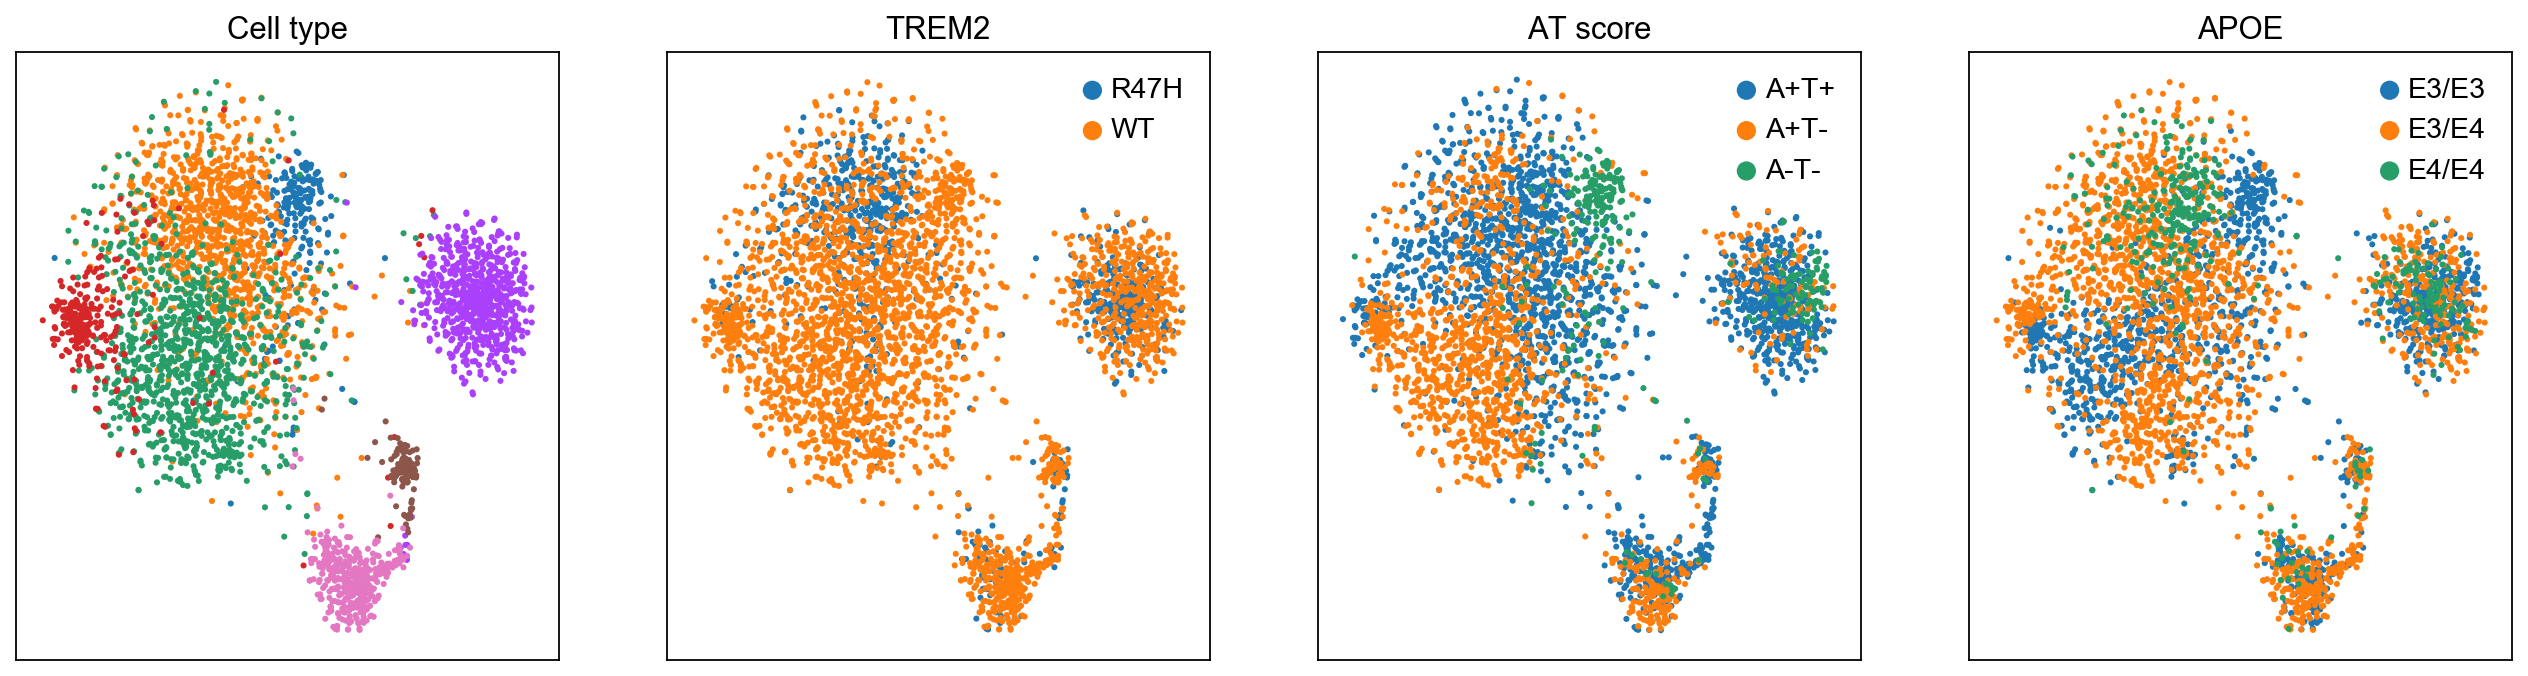

In [41]:
ires='0.8'
microglia.obsm.X_tsne=microglia.obsm['X_tsne'+ires]
ncols=4
nrows=1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[ncols*5,nrows*5])
ax=sc.pl.scatter(microglia,basis='tsne',color='mictype',title='Cell type',ax=axes[0],show=False,legend_fontsize=10)
axes[0].get_legend().remove()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax=sc.pl.scatter(microglia,basis='tsne',color='trem2',title='TREM2',legend_loc='upper right',ax=axes[1],show=False)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax=sc.pl.scatter(microglia,basis='tsne',color='atscore',title='AT score',legend_loc='upper right',ax=axes[2],show=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax=sc.pl.scatter(microglia,basis='tsne',color='apoe',title='APOE',legend_loc='upper right',ax=axes[3],show=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)



In [35]:
microglia.obs['mictype'].value_counts()

Motile           1147
ARM              1119
Oli_microglia     690
Ex_microglia      392
Dystrophic        278
Homeostatic       229
Ast_microglia     127
Name: mictype, dtype: int64

In [36]:
submic=microglia[(microglia.obs['mictype']=='ARM')|(microglia.obs['mictype']=='Motile')|
                 (microglia.obs['mictype']=='Dystrophic')|(microglia.obs['mictype']=="Homeostatic")]
                 

DE analysis by wilcoxon rank sum test applied in Scanpy. Two cases: one vs rest and other three vs HOMO

CASE 1: one vs rest

In [66]:
# These script should run in LINUX not windows, sc.tl.rank_genes_groups perform difference in two platform
sc.tl.rank_genes_groups(submic, "mictype",
                       groups=['Homeostatic','ARM','Motile','Dystrophic'],
                        method='wilcoxon',
                        n_genes=submic.raw.var_names.size,
                        rankby_abs=True)

C:\Users\wangk\AppData\Roaming\Python\Python37\site-packages\scanpy\tools\_rank_genes_groups.py:370: RuntimeWarning: overflow encountered in long_scalars
  (ns[imask] * (n_cells - ns[imask]) * (n_cells + 1) / 12))


In [45]:
def rank_genes_groups_df(adata, group, pval_cutoff : float =None, logfc_cutoff=None): 
    d = pd.DataFrame() 
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']: 
        d[k] = adata.uns["rank_genes_groups"][k][group] 
    if pval_cutoff is not None: 
        d = d[d["pvals_adj"] < pval_cutoff] 
    if logfc_cutoff is not None: 
        d = d[d["logfoldchanges"].abs() > logfc_cutoff] 
    return d

In [48]:
log_fc_threshold=0.1
pval_adj_threshold=0.05

In [68]:

de=[]
de_homo = rank_genes_groups_df(submic, 'Homeostatic')
de_arm = rank_genes_groups_df(submic, 'ARM')
de_motile = rank_genes_groups_df(submic, 'Motile')
de_dys = rank_genes_groups_df(submic, 'Dystrophic')

de.append(de_homo)
de.append(de_arm)
de.append(de_motile)
de.append(de_dys)
savefile=["w_homo",'w_arm','w_mot','w_dys']


N=4

for i in range(N):

    de_pos=de[i][(de[i].logfoldchanges>log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
    de_pos.sort_values('pvals_adj',inplace=True)
    
    de_neg=de[i][(de[i].logfoldchanges<-log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
    de_neg.sort_values('pvals_adj',inplace=True)

    de_pos.to_csv(savefile[i]+"_pos.csv")
    de_neg.to_csv(savefile[i]+"_neg.csv")



In [69]:

de_pos_homo=de_homo[(de_homo.logfoldchanges>log_fc_threshold)&(de_homo.pvals_adj<pval_adj_threshold)]
de_pos_homo.sort_values('pvals_adj',inplace=True)
de_pos_homo.head()

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,scores,names,logfoldchanges,pvals,pvals_adj
3,9.575580,FRMD4A,1.244736,1.012879e-21,6.690823e-18
7,8.031395,SFMBT2,1.433935,9.637045e-16,3.182995e-12
8,7.499418,AC120193.1,1.504748,6.410157e-14,1.881951e-10
9,7.431903,AC068992.1,4.262547,1.070459e-13,2.828473e-10
10,7.252969,AC008691.1,3.208752,4.077321e-13,9.794096e-10


In [70]:
de_neg_homo=de_homo[(de_homo.logfoldchanges<-log_fc_threshold)&(de_homo.pvals_adj<pval_adj_threshold)]
de_neg_homo.sort_values('pvals_adj',inplace=True)
de_neg_homo.head()

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,scores,names,logfoldchanges,pvals,pvals_adj
0,-12.647748,NEAT1,-2.312541,1.151283e-36,3.042035e-32
1,-11.580046,SLC26A3,-2.328851,5.201821e-31,6.872386e-27
2,-10.786842,FKBP5,-3.545546,3.972054e-27,3.498452e-23
4,-9.420601,DPYD,-3.074943,4.485143e-21,2.370219e-17
5,-8.901549,SLC1A3,-1.497096,5.507224e-19,2.425290e-15


CASE 2: Arm, Motile, Dysgtrophic vs HOMOE

In [71]:
sc.tl.rank_genes_groups(submic, "mictype",
                        groups=['ARM','Motile','Dystrophic'],
                        reference="Homeostatic",
                        method='wilcoxon',
                        n_genes=submic.raw.var_names.size,
                        rankby_abs=True)

In [72]:
de_arm_h = rank_genes_groups_df(submic, 'ARM')
de_mot_h = rank_genes_groups_df(submic, 'Motile')
de_dys_h = rank_genes_groups_df(submic, 'Dystrophic')

In [74]:
de=[]

de.append(de_arm_h)
de.append(de_mot_h)
de.append(de_dys_h)
savefile=['w_arm_h','w_mot_h','w_dys_h']


N=3

for i in range(N):

    de_pos=de[i][(de[i].logfoldchanges>log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
    de_pos.sort_values('pvals_adj',inplace=True)
    
    de_neg=de[i][(de[i].logfoldchanges<-log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
    de_neg.sort_values('pvals_adj',inplace=True)

    de_pos.to_csv(savefile[i]+"_pos.csv")
    de_neg.to_csv(savefile[i]+"_neg.csv")

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [75]:
i=0 # arm_vs_homo
de_pos=de[i][(de[i].logfoldchanges>log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
de_pos.sort_values('pvals_adj',inplace=True)
de_pos.head()

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,scores,names,logfoldchanges,pvals,pvals_adj
1,12.081801,SLC26A3,2.513461,1.317995e-33,1.741269e-29
2,11.397553,NEAT1,2.180482,4.300338e-30,3.787594e-26
3,10.581952,DPYD,3.488856,3.613500e-26,2.386988e-22
6,9.791317,FKBP5,3.413069,1.226873e-22,4.631093e-19
7,9.542397,SLC1A3,1.691859,1.395673e-21,4.609732e-18


In [76]:
i=1 # motile_vs_homo
de_pos=de[i][(de[i].logfoldchanges>log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
de_pos.sort_values('pvals_adj',inplace=True)
de_pos.head()

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,scores,names,logfoldchanges,pvals,pvals_adj
0,13.623844,NEAT1,2.520373,2.889481e-42,7.634876e-38
1,10.718767,FKBP5,3.671437,8.310355e-27,1.097923e-22
2,8.828892,SLC26A3,1.938071,1.057182e-18,9.311303e-15
3,7.947751,SLC1A3,1.368051,1.899279e-15,1.254616e-11
5,7.667789,APOE,1.923241,1.749855e-14,7.706070e-11


In [77]:
i=2 # dystrohpic_vs_homo
de_pos=de[i][(de[i].logfoldchanges>log_fc_threshold)&(de[i].pvals_adj<pval_adj_threshold)]
de_pos.sort_values('pvals_adj',inplace=True)
de_pos.head()

C:\Users\wangk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,scores,names,logfoldchanges,pvals,pvals_adj
0,15.575459,FTL,3.922354,1.068825e-54,2.824156e-50
1,13.127926,SLC26A3,3.167222,2.278097e-39,3.009707e-35
2,11.868525,RPS6,4.330101,1.724818e-32,1.519162e-28
3,11.729336,FTH1,2.991559,9.016316e-32,5.955953e-28
4,10.799176,RPL19,4.029462,3.473063e-27,1.835375e-23
